# Imports and Definitions

In [13]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from shapely.geometry import Point, LineString
import requests
import contextily as ctx
from bs4 import BeautifulSoup
import os
import re
import time
import cProfile
from tqdm import tqdm
import numpy as np

from HEdata import MIDAS, NTIS
from HEdata.utils import show_sites, plot_map

sns.set_style("white")
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# MIDAS sites

In [42]:
midas = MIDAS(version=1.0)

### MIDAS sites locations

In [43]:
midas_sites = midas.sites()

INFO:HEdata:17846 sites received
INFO:HEdata:Filtered non-active sites, 10301 sites remaining
INFO:HEdata:Filtered MIDAS only sites, 7249 sites remaining


INFO:HEdata:Getting report for date range 01042019 - 04042019 for sites 2


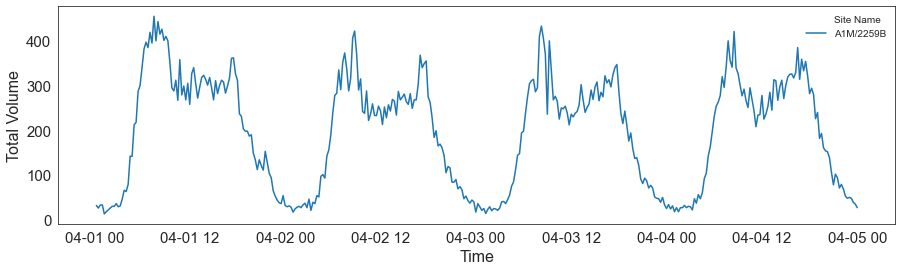

In [44]:
midas.plot_report(
    midas.daily_report(
        "01-04-2019",
        "04-04-2019",
        midas.sites_in_link(midas_sites, "126046101")["Id"].values,
    )
)

In [38]:
rep = midas.daily_report("01-04-2019", "04-04-2019", [2, 3, 4])

INFO:Webtris:Getting report for date range 01042019 - 04042019 for sites 2,3,4


In [52]:
midas_sites.groupby(["link_id"]).size().sort_values(ascending=False)

link_id
102004801    42
102004601    41
200047941    31
108018902    29
123008901    29
             ..
199095501     1
115020301     1
115020401     1
115020501     1
101000501     1
Length: 2794, dtype: int64

> approach for anomaly detection or malfunctioning site
windowed correlation for sensors in a link.
Median absolute deviation

In [214]:
from scipy.stats import ks_2samp

In [222]:
df_f = pd.DataFrame(index=df_piv.columns, columns=df_piv.columns)

In [241]:
for col_i in df_piv.columns:
    for col_j in df_piv.columns:
        df_f.loc[col_i, col_j] = float(
            ks_2samp(df_piv[col_i].values, df_piv[col_j].values)[1]
        )

/Users/markd/projects/he/he/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning:

invalid value encountered in less_equal



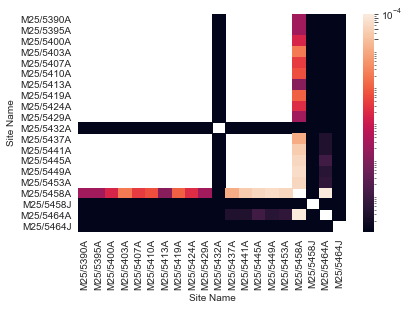

In [279]:
from matplotlib.colors import LogNorm

sns.heatmap(
    df_f[df_f < 0.01].astype(float), norm=LogNorm(), vmin=10 ** -10, vmax=10 ** -4
)

In [219]:
df_piv = (
    df_199055701[["Site Name", "Total Volume", "time"]]
    .pivot(index="time", columns="Site Name", values="Total Volume")
    .fillna(0)
)

> MIDAS Sites within the same link, drastically different volumes

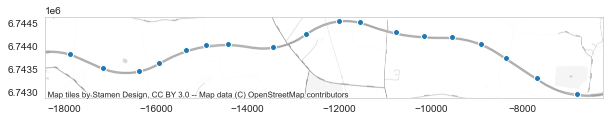

In [117]:
show_sites(
    midas_sites[midas_sites["Description"].isin(df_199055701["Site Name"].unique())],
    backend="geopandas",
)

In [193]:
df_102004801 = midas.daily_report(
    start="01-11-2019",
    end="04-11-2019",
    sites="179,314,319,466,502,685,874,1278,1334,1470,1692",
)

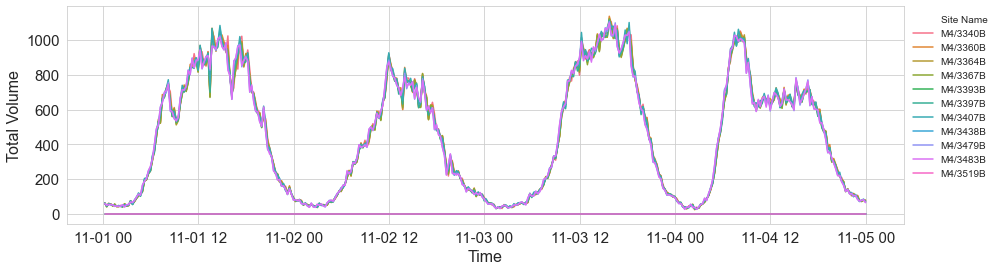

In [196]:
plot_report(df_102004801)

### Random sites example

In [109]:
df = midas.daily_report(start="01-11-2016", end="05-11-2016", sites="1,2,3,5,6")

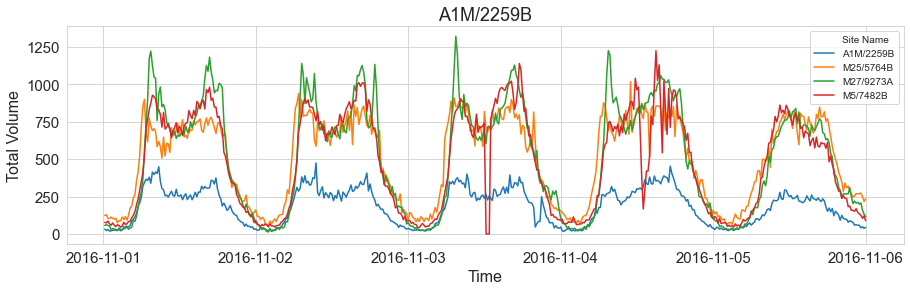

In [110]:
plot_report(df)

In [17]:
import xml.etree.ElementTree as ET

In [18]:
ns = {"ns": "http://datex2.eu/schema/2/2_0"}  # Namespace

In [19]:
root = ET.parse(
    "NTISModel-2020-03-31-v12.0/NTISModel-MeasurementSites-2020-03-31-v12.0.xml"
).getroot()

In [11]:
sites = root.findall(".//ns:measurementSiteRecord", namespaces=ns)

NameError: name 'root' is not defined

In [84]:
len(sites)

11825

In [79]:
sites[110].findall(".//ns:specificLane", namespaces=ns)[0].text

'allLanesCompleteCarriageway'

In [ ]:
sites

In [83]:
sites.findall(".//ns:linearElementIdentifier", namespaces=ns)[0].t

AttributeError: 'list' object has no attribute 'findall'

In [68]:
aa = []
for site in sites:
    try:
        aa.append(site.findall(".//ns:specificLane", namespaces=ns)[0].text)
    except:
        pass

In [71]:
set(aa)

{'allLanesCompleteCarriageway', 'hardShoulder', 'lane1'}

# NTIS model

In [58]:
ntis = NTIS(
    "NTISModel-2020-03-31-v12.0/NTISModel-PredefinedLocations-2020-03-31-v12.0.xml"
)

In [59]:
df_ntis_links = ntis.get_links()

100%|██████████| 18592/18592 [00:02<00:00, 6294.06it/s] 


Number of links found: 18592


In [60]:
gdf_ntis_shapes = ntis.get_links_shapes()

100%|██████████| 18592/18592 [00:01<00:00, 9625.91it/s] 

Number of links found: 18592


In [61]:
gdf_ntis_nodes = ntis.get_nodes()

100%|██████████| 15831/15831 [00:01<00:00, 12138.73it/s]


Number of nodes found: 15831


In [62]:
df_hatris = ntis.get_HATRIS_sections()

100%|██████████| 2396/2396 [00:00<00:00, 44560.11it/s]

Number of sections found: 2396


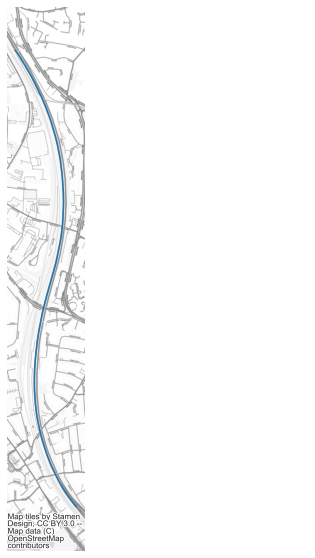

In [68]:
plot_map(gdf_ntis_shapes[gdf_ntis_shapes["link_id"] == "199112202"])

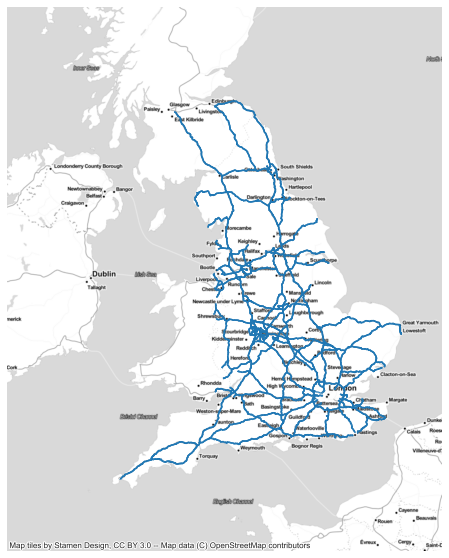

In [64]:
plot_map(gdf_ntis_shapes)

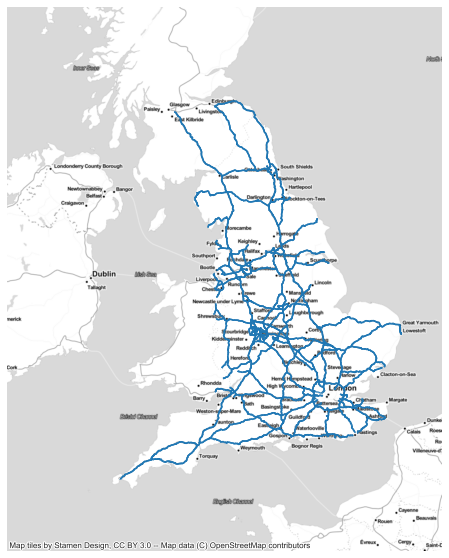

In [38]:
plot_map(gdf_ntis_shapes)

# HAPMS models

In [72]:
# https://data.gov.uk/dataset/2b0dd22d-213e-4f5b-99da-8b5ec409112c/highways-england-pavement-management-system-network-layer

In [69]:
hapms_file = "hapms/network20200302.shp"

In [70]:
hapms = gpd.read_file(hapms_file)

In [75]:
len(hapms)

21491

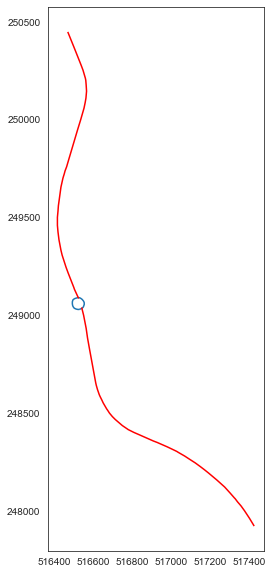

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
hapms.loc[[3]].plot(ax=ax)
gdf_ntis_shapes[gdf_ntis_shapes["link_id"].isin(["126044101", "108000803"])].to_crs(
    "epsg:27700"
).plot(ax=ax, color="red")

In [77]:
gpd.sjoin(hapms, gdf_ntis_shapes.to_crs("epsg:27700"), op="intersects", how="left")

,class_name,roa_number,sect_label,location,start_date,s_end_date,sec_length,funct_name,area_name,direc_code,...,dsegrefekc,dsegrefsd,dsegrefed,dsegrefslo,dsegrefsro,dsegrefelo,dsegrefero,geometry,index_right,link_id
0,A,A1,0200A1/156,Exit Slip B658 to Sandy Roundabout,1990-01-23,3000-01-01,710.0,Main Carriageway,Area 8,NB,...,368345.0,0.0,710.0,-4274.635879,4274.635879,-4274.635879,4274.635879,"LINESTRING (516772.151 248405.253, 516767.937 ...",NaN,NaN
1,A,A1,0200A1/188,End Entry Slip from Junction 10 (A1M) to C171 ...,1990-01-23,3000-01-01,1586.0,Main Carriageway,Area 8,NB,...,368347.0,0.0,1586.0,-4274.635879,4274.635879,-4274.635879,4274.635879,"LINESTRING (523106.114 237093.441, 523096.851 ...",NaN,NaN
2,A,A1,0200A1/173,A6001 Underbridge to Biggleswade South Roundabout,1990-01-23,3000-01-01,1719.0,Main Carriageway,Area 8,SB,...,368348.0,0.0,1719.0,-4274.635879,4274.635879,-4274.635879,4274.635879,"LINESTRING (518971.906 243566.853, 518980.731 ...",14317.0,108006601
3,A,A1,0200A1/152,Sandy Roundabout,1990-01-23,3000-01-01,211.0,Roundabout,Area 8,CW,...,368351.0,0.0,211.0,-4274.635879,4274.635879,-4274.635879,4274.635879,"LINESTRING (516532.956 249031.699, 516524.278 ...",11010.0,126044101
3,A,A1,0200A1/152,Sandy Roundabout,1990-01-23,3000-01-01,211.0,Roundabout,Area 8,CW,...,368351.0,0.0,211.0,-4274.635879,4274.635879,-4274.635879,4274.635879,"LINESTRING (516532.956 249031.699, 516524.278 ...",14180.0,108000803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21486,A,A4123,4620A4123/144,M5 junction 2 roundabout exit to retail park,2020-02-01,3000-01-01,10.0,Slip Road,Area 9,NB,...,20954971.0,0.0,10.0,-4274.635879,4274.635879,-4274.635879,4274.635879,"LINESTRING (398869.356 288274.511, 398870.789 ...",NaN,NaN
21487,A,A4123,4620A4123/145,M5 junction 2 entry to roundabout from retail ...,2020-02-01,3000-01-01,8.0,Slip Road,Area 9,NB,...,20954975.0,0.0,8.0,-4274.635879,4274.635879,-4274.635879,4274.635879,"LINESTRING (398866.560 288259.698, 398864.066 ...",NaN,NaN
21488,M,M5,0100M5/561,M5 (A) (SLIP) Slip off Jct 19 (MP 144/0-144/6),2020-02-27,3000-01-01,632.0,Slip Road,South West,SB,...,20954979.0,0.0,632.0,-4274.635879,4274.635879,-4274.635879,4274.635879,"LINESTRING (351557.643 176268.425, 351493.342 ...",NaN,NaN
21489,M,M5,0100M5/562,M5 (A) (SLIP) Slip off Jct 19 (2 Lanes) (MP 14...,2020-02-27,3000-01-01,427.0,Slip Road,South West,SB,...,20954980.0,0.0,427.0,-4274.635879,4274.635879,-4274.635879,4274.635879,"LINESTRING (351131.513 175804.681, 351085.541 ...",17231.0,102014401


In [71]:
hapms.crs = "epsg:27700"

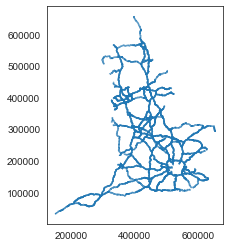

In [74]:
hapms.plot()

In [165]:
midas_buff = midas_sites[
    midas_sites["Description"].isin(df_199055701["Site Name"].unique())
].copy()
midas_buff["geometry"] = midas_buff["geometry"].buffer(5)
sites_hapms_join = gpd.sjoin(midas_buff, hapms, how="left", op="intersects")

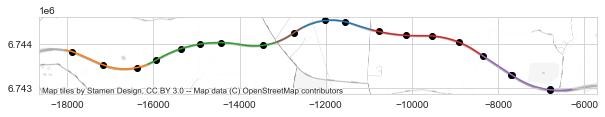

In [172]:
fig, ax = plt.subplots(figsize=(10, 10))
i = -1
for sect in sites_hapms_join["sect_label"].unique():
    i = i + 1
    hapms[hapms["sect_label"].isin([sect])].to_crs("epsg:3857").plot(
        ax=ax, color=sns.color_palette()[i]
    )
midas_sites[midas_sites["Description"].isin(df_199055701["Site Name"].unique())].to_crs(
    "epsg:3857"
).plot(ax=ax, color="k")
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

> multiple HAPMS sections in a single SRN link. \
This required a buffering of 5 meters ot match line segments with points
as the points are not exactly located to the road resolution

In [196]:
sites_clean_buff = sites_clean.copy()
sites_clean_buff["geometry"] = sites_clean_buff["geometry"].buffer(10)
sites_hapms_join = gpd.sjoin(sites_clean_buff, hapms_gdf, how="left", op="intersects")

In [202]:
sites_hapms_join[["sect_label", "location"]]

,sect_label,location
1,0500A1M/298,None
2,1800M5/201,M5 Northbound. From Centre of Junction 7 Round...
2,1800M5/207,M5 Junction 7 Northbound Entry Slip.
3,1700M3/969,From start spur to J14 Chilworth MP 116.8 + 63...
4,1500M25/175,End of HRA over A127 to end of NB slip on fro...
...,...,...
17842,4600M5/16,M5 Southbound. From start of Oldbury viaduct t...
17843,0600M62/180,EB 34/0 (end of access) - 35/39
17844,4200M60/933,ACW link from M62 (starts at split to M60 CW -...
17845,0600M62/122,EB 28/5+50 - 29/4+90 (c/l M6)


In [210]:
fig, ax = plt.subplots(figsize=(20, 20))
sites_clean.loc[[10784]].to_crs("epsg:3857").plot(ax=ax)
midas_hapms.to_crs("epsg:3857").plot(ax=ax)
ctx.add_basemap(ax, zoom=10)

In [348]:
midas_hapms["geometry"] = midas_hapms["geometry"].buffer(100)

In [396]:
len(midas_hapms[~midas_hapms["sect_label"].isna()]) / len(midas_hapms)

0.24825513765025203

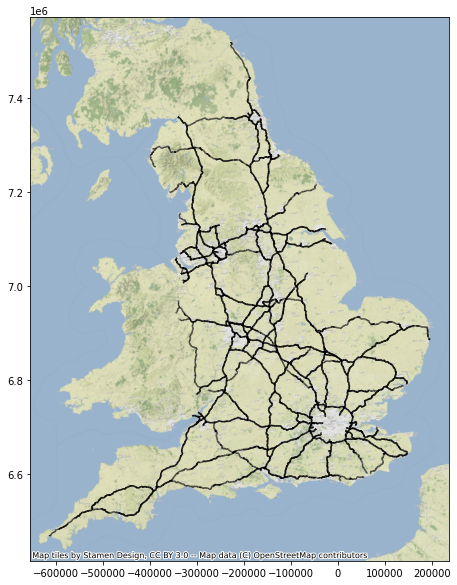

In [351]:
fig, ax = plt.subplots(figsize=(10, 10))
midas_hapms.to_crs("epsg:3857").plot(ax=ax, edgecolor="w", color="blue", alpha=1)
hapms_gdf.to_crs("epsg:3857").plot(ax=ax, color="k", alpha=0.7)
ctx.add_basemap(ax, zoom=10)

# HATRIS

In [55]:
df_hatris = pd.read_csv("/Users/markd/projects/he/hatris.csv")


def start_pipe(df):
    return df.copy()


def clean(df):
    df.dropna(subset=["StartX"], inplace=True)
    return df


def create_geom(df):
    df["geometry"] = df.apply(
        lambda x: LineString([(x["StartX"], x["StartY"]), (x["EndX"], x["EndY"])]),
        axis=1,
    )

    return df


def convert_to_gdf(df):
    gdf = gpd.GeoDataFrame(df)
    gdf.crs = "epsg:27700"
    return gdf

In [56]:
hatris_links = (
    df_hatris.pipe(start_pipe).pipe(clean).pipe(create_geom).pipe(convert_to_gdf)
)

In [57]:
hatris_links

,LinkRef,LinkDescription,StartJunction,EndJunction,StartX,StartY,EndX,EndY,geometry
0,AL1000,A38 between A513 and A5127 (AL1000),A513,A5127,417216.0,314346.0,414414.0,310549.0,"LINESTRING (417216.000 314346.000, 414414.000 ..."
1,AL1001,A38 between A5127 and A513 (AL1001),A5127,A513,414399.0,310543.0,417204.0,314350.0,"LINESTRING (414399.000 310543.000, 417204.000 ..."
2,AL1004,A38 between A513 and A5121 (AL1004),A513,A5121,417204.0,314350.0,421987.0,321236.0,"LINESTRING (417204.000 314350.000, 421987.000 ..."
3,AL1007,A38 between A5121 and A513 (AL1007),A5121,A513,422031.0,321346.0,417216.0,314346.0,"LINESTRING (422031.000 321346.000, 417216.000 ..."
4,AL1012,A42 between A511 and M42 J11 (AL1012),A511,M42 J11,437463.0,317050.0,430734.0,310772.0,"LINESTRING (437463.000 317050.000, 430734.000 ..."
...,...,...,...,...,...,...,...,...,...
2505,LM997,M6 between M6 J3 and M6 J2 (LM997),M6 J3,M6 J2,434401.0,285186.0,438783.0,282393.0,"LINESTRING (434401.000 285186.000, 438783.000 ..."
2506,LM998C,M6 between M6 J3 and M6 J3A (LM998C),M6 J3,M6 J3A,434600.0,285053.0,421646.0,286614.0,"LINESTRING (434600.000 285053.000, 421646.000 ..."
2507,LM998D,M6 between M6 J3A and M6 J4 (LM998D),M6 J3A,M6 J4,421646.0,286614.0,420042.0,286561.0,"LINESTRING (421646.000 286614.000, 420042.000 ..."
2508,LM999C,M6 between M6 J3A and M6 J3 (LM999C),M6 J3A,M6 J3,422448.0,286244.0,434401.0,285186.0,"LINESTRING (422448.000 286244.000, 434401.000 ..."


(7400000.0, 7600000.0)

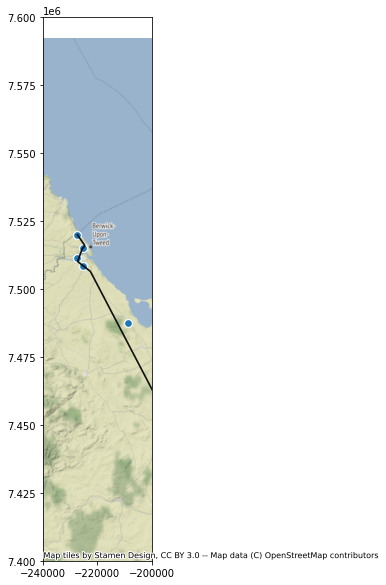

In [407]:
fig, ax = plt.subplots(figsize=(10, 10))
sites_clean.to_crs("epsg:3857").plot(ax=ax, edgecolor="w", alpha=1, markersize=60)
hatris_links.to_crs("epsg:3857").plot(ax=ax, color="k", alpha=0.7)
ctx.add_basemap(ax, zoom=10)
ax.set_xlim([-240000, -200000])
ax.set_ylim([7.4e6, 7.6e6])